In [53]:
import numpy as np
import baseline_model
from casadi import *
import do_mpc
import decentralized as dec
import util
import sim_drone_main
from baseline_model import baseline_drone_model
from baseline_model_mpc import baseline_drone_mpc
from baseline_model_simulator import baseline_drone_simulator
import itertools

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
Q = np.eye(6)
R = np.eye(3)
n_agents = 3
n_inputs = 3
n_states = 6
Qf = Q*1e3

In [56]:
Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents

In [57]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(6, 1))
u = model.set_variable(var_type='_u', var_name='u', shape=(3, 1))
print(f'Shape of x is {x.shape}')
print(f'Shape of u is {u.shape}')
#x = p_x,p_y,p_z,v_x,v_y,v_z
#u = theta, phi, tau
g = 9.81
model.set_rhs('x', vertcat(x[3], x[4], x[5], g*np.tan(u[0]), -g*np.tan(u[1]), u[2]-g))

Shape of x is (6, 1)
Shape of u is (3, 1)


In [58]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 5

x_dims = [6,6,6]

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode=200
x_baseline_init, x_baseline_f = util.paper_setup_3_quads() 
#concatenated initial and final states of all 3 agents

x_baseline1 = x_baseline_init

states_list = np.zeros((episode+1,9)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [59]:
baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[0].flatten(), Q, R, Qf,x_baseline1,x_dims)

In [60]:
model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, R, Qf, x_baseline1, x_dims) for i in range(n_agents)]

In [61]:
mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline1,x_dims, v_max, theta_max, phi_max, tau_max) for model_i in model_baseline]

/home/randy233/anaconda3/envs/Randy/lib/python3.10/site-packages/do_mpc/controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [62]:
simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]

In [71]:
dec.split_agents(x_baseline1.reshape(1,-1),x_dims)[0]

array([[0.499, 1.518, 0.979, 0.   , 0.   , 0.   ]])

In [72]:
simulator_baseline

In [73]:
split_states = dec.split_agents(x_baseline1.reshape(1,-1),x_dims)
for m in range(len(simulator_baseline)):
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

In [74]:
u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
u_dims = [3,3,3]

In [75]:
split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
split_inputs

[array([[0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.]])]

In [76]:
u0_baseline = []
x_baseline_next = []
for m in range(len(mpc_baseline)):
    mpc_baseline[m].u0 = split_inputs[m].T
    simulator_baseline[m].u0 = split_inputs[m].T
    mpc_baseline[m].set_initial_guess()
    u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
    x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T)) #???

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2561208e+03 4.91e-01 1.36e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [98]:
# [mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))][0]

In [99]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 2

x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode= 10
x_baseline_init, x_baseline_f = util.paper_setup_3_quads()

x_baseline1 = x_baseline_init #concatenated states of all agents

states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [100]:
n_agents = 3
n_states = 6
n_inputs = 3

def setup_baseline(x_baseline, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                    x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius):
    model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, \
                     R, Qf, x_baseline, x_dims) for i in range(n_agents)] 
    #a list of baseline models for each agent
    
    mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline, x_dims, v_max, theta_max, phi_max,\
                   tau_max) for model_i in model_baseline]
    #a list of baseline mpc controllers for each agent
    
    simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]
    
    #splitting the states of each agent
    split_states = dec.split_agents(x_baseline.reshape(1,-1),x_dims)

    for m in range(len(simulator_baseline)):
        
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

    u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
    split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
    
    u0_baseline = []
    x_baseline_next = []
    for m in range(len(mpc_baseline)):
        mpc_baseline[m].u0 = split_inputs[m].T
        simulator_baseline[m].u0 = split_inputs[m].T
        mpc_baseline[m].set_initial_guess()
        u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
        x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T))

    return u0_baseline, x_baseline_next, [mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))]
    #last _lam_g_num is the Lagrange multiplier

In [101]:
import concurrent.futures
import time

In [102]:
states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()


In [115]:
pos_prev = np.array([x_baseline1[0], x_baseline1[1], x_baseline1[2],\
                        x_baseline1[6], x_baseline1[7], x_baseline1[8], \
                        x_baseline1[12], x_baseline1[13], x_baseline1[14]])
    
velocity_prev = np.zeros((n_agents*3,1))

In [116]:
time_start = time.perf_counter()
results = []

with concurrent.futures.ProcessPoolExecutor(100) as executor:

        for k in range(episode):
            f = executor.submit(setup_baseline,x_baseline1, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                        x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius)
            """
            TODO:separate the states of each agent from f.result()
            """
            results.append(f)

            for m in range(n_agents):
                #Note: f.result()[1] returns state vectors of all drones;
                #f.result()[1][m] returns state vector of drone m;
                ##f.result()[1][m][0:3] returns the position vector only
                
                #Append current positions of each drone to states_list:
                states_list[k+1,m*3:(m+1)*3] = f.result()[1][m][0:3].flatten() 
                #velocity components will be estimated through finite-difference approx.

            # print("Lagrange Multiplier: ", la_mul)
            # print("Length of Lagrange Multiplier: ", len(la_mul[0]))
        # ------------------------------------------------------------
               
            for j in range(n_agents):
                #position update:
                x_baseline1[(j+1-1)*3+j*3:(j+1)*3+j*3]  = states_list[k+1,j*3:(j+1)*3].reshape(-1,1) 
                #velocity update via finite-diff:
                x_baseline1[(j+1)*3+j*3:(j+2)*3+j*3]  = -(pos_prev[j*3:(j+1)*3] - states_list[k+1,j*3:(j+1)*3].reshape(-1,1) ) / 0.1
            
            for n in range(n_agents):
                pos_prev[n*3:(n+1)*3] = x_baseline1[(n+1)*3+n*3:(n+2)*3+n*3]
                
time_finish = time.perf_counter()
print("Total time: ", time_finish - time_start) 

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5757017e+05 7.54e-01 1.99e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [117]:
states_list[-1]

array([ 16639608.926,  50693056.103,  45458803.209, -10381520.841,
        -6249337.145,  -7059594.33 ,  -6240202.591,  -5385483.879,
        -7442217.784])

In [146]:
# f.result()[1][0][0:3].flatten().shape ->pos vector of drone 0 at time step 0

In [34]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [35]:
data_baseline = np.load('drone_sim_data.npy')

In [36]:
dataSet = data_baseline
# print(dataSet)
# print(dataSet.shape)
numDataPoints = 50
 


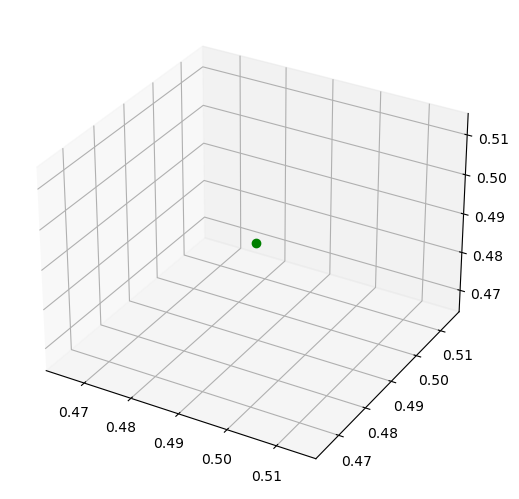

In [37]:
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
dotsEgo = ax.plot(dataSet[0][0], dataSet[1][0], dataSet[2][0], 'go')[0] # For scatter plot
x=np.linspace(0, 45, numDataPoints)